In [39]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [40]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [41]:
#pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from functools import partial
from time import time

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
import pickle
from skimage import io
import cv2

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import CharErrorRate as CER


import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import os
from skimage.transform import resize
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import math

from matplotlib import rcParams
rcParams['figure.figsize'] = (12,6)

In [ ]:
!unzip /content/gdrive/MyDrive/CCPD2019-dl1.zip -d '/content/data'

# Функции и классы

In [44]:
#@title Реализация класса  для подготовки датасета. И функция создания даталоадера
class PrepareDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = files
        self.labels = [file.name[-11:-4] for file in files]
        # режим работы
        self.mode = mode

        if self.mode not in ['train', 'val', 'test']:
            print(f"{self.mode} is not correct; correct modes: {['train', 'val', 'test']}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            #self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            y = label
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((imW, imH))
        return np.array(image)

def get_dataloader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=6)

In [45]:
#@title Реализация токенизатора для СТС loss

OOV_TOKEN = '<OOV>'
CTC_BLANK = '<BLANK>'

def get_char_map(alphabet):
    """Make from string alphabet character2int dict.
    Add BLANK char fro CTC loss and OOV char for out of vocabulary symbols."""
    char_map = {value: idx + 2 for (idx, value) in enumerate(alphabet)}
    char_map[CTC_BLANK] = 0
    char_map[OOV_TOKEN] = 1
    return char_map

class Tokenizer:
    """Class for encoding and decoding string word to sequence of int
    (and vice versa) using alphabet."""

    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        """Returns a list of encoded words (int)."""
        enc_words = []
        for word in word_list:
            enc_words.append(
                [self.char_map[char] if char in self.char_map
                 else self.char_map[OOV_TOKEN]
                 for char in word]
            )
        return torch.tensor(enc_words)

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        """Returns a list of words (str) after removing blanks and collapsing
        repeating characters. Also skip out of vocabulary token."""
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                if (
                    char_enc != self.char_map[OOV_TOKEN]
                    and char_enc != self.char_map[CTC_BLANK]
                    and not (idx > 0 and char_enc == word[idx - 1])
                ):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words

In [46]:
#@title функции для подсчёта метрик (СЕR и Accuracy)

class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_CER(y_pred, y_real):
    metric = CER()
    return metric(y_pred, y_real)

def get_accuracy(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        scores.append(true == pred)
    avg_score = np.mean(scores)
    return avg_score

# Подготовка датасета и аугментация данных

Я решил не делать валидационную часть, а взял сразу тестовую. Потому что в нашем случае моделька всё равно учится на тренировочной части, а больше данных - несомненно лучше, чем меньше данных)

In [47]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [48]:
train_dir = Path('/content/data/CCPD2019-dl1/train')
val_dir = Path('/content/data/CCPD2019-dl1/test')

In [49]:
train_files = sorted(list(train_dir.rglob('*.jpg')))
val_files = sorted(list(val_dir.rglob('*.jpg')))
print(len(train_files), len(val_files))

199980 9999


In [50]:
imW = 100
imH = 32
batch_size = 16

alphabet = '皖沪津渝冀晋蒙辽吉黑苏浙京闽赣鲁豫鄂湘粤桂琼川贵云藏陕甘青宁新警学ABCDEFGHJKLMNOPQRSTUVWXYZ1234567890'

model_save_path = '/content/model_weights'

In [51]:
provinces = np.array([file.name[-11:-10] for file in train_files])

In [52]:
prov_map = {}
i = 0
provinces_count = np.unique(provinces, return_counts=True)
for prov in provinces_count[0]:
    prov_map[prov] = provinces_count[1][i]
    i += 1
prov_map

{'云': 17,
 '京': 307,
 '冀': 175,
 '吉': 13,
 '宁': 5,
 '川': 121,
 '新': 16,
 '晋': 67,
 '桂': 15,
 '沪': 663,
 '津': 60,
 '浙': 1349,
 '渝': 74,
 '湘': 96,
 '琼': 9,
 '甘': 18,
 '皖': 191796,
 '粤': 373,
 '苏': 3311,
 '蒙': 19,
 '藏': 1,
 '豫': 431,
 '贵': 16,
 '赣': 151,
 '辽': 59,
 '鄂': 278,
 '闽': 208,
 '陕': 55,
 '青': 11,
 '鲁': 248,
 '黑': 18}

Как можно заметить, подавляющее большинство провинцей - 皖. А остальных провинцей практически нет. Это плохо, потому что модель обучится предсказывать 皖. Поэтому я сделаю балансировку классов и дополню файлы фотографиями номеров тех провинций, которых мало. Поэтому я дополню список файлов тех провинций, у которых мало фотографий до 200

In [53]:
while prov_map['藏'] < 200:
    size = len(train_files)
    for i in range(size):
        if prov_map[provinces[i]] < 20:
            for j in range(20):
                train_files.append(train_files[i])
            prov_map[provinces[i]] += 20
        elif prov_map[provinces[i]] < 200:
            train_files.append(train_files[i])
            prov_map[provinces[i]] += 1
    provinces = np.array([file.name[-11:-10] for file in train_files])

In [54]:
len(train_files)

203164

In [55]:
provinces = np.array([file.name[-11:-10] for file in train_files])
provinces_count = np.array(np.unique(provinces, return_counts=True)).T
print(provinces_count)

[['云' '200']
 ['京' '307']
 ['冀' '200']
 ['吉' '200']
 ['宁' '200']
 ['川' '200']
 ['新' '200']
 ['晋' '200']
 ['桂' '200']
 ['沪' '663']
 ['津' '200']
 ['浙' '1349']
 ['渝' '200']
 ['湘' '200']
 ['琼' '200']
 ['甘' '200']
 ['皖' '191796']
 ['粤' '373']
 ['苏' '3311']
 ['蒙' '200']
 ['藏' '200']
 ['豫' '431']
 ['贵' '200']
 ['赣' '200']
 ['辽' '200']
 ['鄂' '278']
 ['闽' '208']
 ['陕' '200']
 ['青' '200']
 ['鲁' '248']
 ['黑' '200']]


Так уже лучше. Также я принял решение, что не буду делать аугментацию данных. Сделаю вот только балансировку классов, потому что данных и так много и моделька и так учится долго, а гпу в колабе небесконечный(

In [56]:
train_dataset = PrepareDataset(train_files,  mode='train')
val_dataset = PrepareDataset(val_files,  mode='val')

In [57]:
print(len(train_dataset), len(val_dataset))

203164 9999


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 30358 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35947 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 35947 missing from current font.
  font.set_text(s, 0, flags=flags)


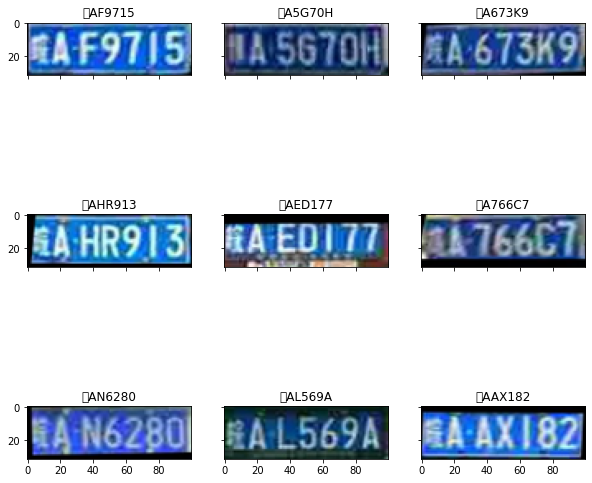

In [58]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(10, 10), \
                        sharey=True, sharex=True)
img_label = []
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label.append(label)
    imshow(im_val.data.cpu(), \
          title=img_label[-1:][0],plt_ax=fig_x)

In [59]:
provinces_val = np.array([file.name[-11:-10] for file in val_files])
prov_map_val = {}
i = 0
provinces_count = np.unique(provinces_val, return_counts=True)
for prov in provinces_count[0]:
    prov_map_val[prov] = provinces_count[1][i]
    i += 1
prov_map_val

{'云': 2,
 '京': 16,
 '冀': 5,
 '吉': 1,
 '宁': 1,
 '川': 5,
 '新': 4,
 '晋': 5,
 '沪': 45,
 '津': 4,
 '浙': 83,
 '渝': 3,
 '湘': 6,
 '琼': 1,
 '甘': 1,
 '皖': 9491,
 '粤': 26,
 '苏': 212,
 '蒙': 5,
 '豫': 19,
 '贵': 2,
 '赣': 10,
 '辽': 4,
 '鄂': 22,
 '闽': 5,
 '陕': 5,
 '青': 1,
 '鲁': 12,
 '黑': 3}

Как можно увидеть, в тестовой выборке есть хотя бы по картинке всех классов, поэтому балансировка классов должна улучшить как максимум - практическое применение модели на практике, как минимум - скор на тестовой выборке для малочисленных классов.

# Подготовка составных частей CRNN и сбор модели

In [60]:
#@title ResNet
class ResNet(nn.Module):

    def __init__(self, input_channel, output_channel, block, layers):
        super(ResNet, self).__init__()

        self.output_channel_block = [int(output_channel / 4), int(output_channel / 2), output_channel, output_channel]

        self.inplanes = int(output_channel / 8)
        self.conv0_1 = nn.Conv2d(input_channel, int(output_channel / 16),
                                 kernel_size=3, stride=1, padding=1, bias=False)
        self.bn0_1 = nn.BatchNorm2d(int(output_channel / 16))
        self.conv0_2 = nn.Conv2d(int(output_channel / 16), self.inplanes,
                                 kernel_size=3, stride=1, padding=1, bias=False)
        self.bn0_2 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.layer1 = self._make_layer(block, self.output_channel_block[0], layers[0])
        self.conv1 = nn.Conv2d(self.output_channel_block[0], self.output_channel_block[
                               0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.output_channel_block[0])

        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.layer2 = self._make_layer(block, self.output_channel_block[1], layers[1], stride=1)
        self.conv2 = nn.Conv2d(self.output_channel_block[1], self.output_channel_block[
                               1], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.output_channel_block[1])

        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=(2, 1), padding=(0, 1))
        self.layer3 = self._make_layer(block, self.output_channel_block[2], layers[2], stride=1)
        self.conv3 = nn.Conv2d(self.output_channel_block[2], self.output_channel_block[
                               2], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.output_channel_block[2])

        self.layer4 = self._make_layer(block, self.output_channel_block[3], layers[3], stride=1)
        self.conv4_1 = nn.Conv2d(self.output_channel_block[3], self.output_channel_block[
                                 3], kernel_size=2, stride=(2, 1), padding=(0, 1), bias=False)
        self.bn4_1 = nn.BatchNorm2d(self.output_channel_block[3])
        self.conv4_2 = nn.Conv2d(self.output_channel_block[3], self.output_channel_block[
                                 3], kernel_size=2, stride=1, padding=0, bias=False)
        self.bn4_2 = nn.BatchNorm2d(self.output_channel_block[3])

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv0_1(x)
        x = self.bn0_1(x)
        x = self.relu(x)
        x = self.conv0_2(x)
        x = self.bn0_2(x)
        x = self.relu(x)

        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.maxpool2(x)
        x = self.layer2(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.maxpool3(x)
        x = self.layer3(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.layer4(x)
        x = self.conv4_1(x)
        x = self.bn4_1(x)
        x = self.relu(x)
        x = self.conv4_2(x)
        x = self.bn4_2(x)
        x = self.relu(x)

        return x

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = self._conv3x3(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = self._conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def _conv3x3(self, in_planes, out_planes, stride=1):
        "3x3 convolution with padding"
        return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                         padding=1, bias=False)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out

class ResNet_FeatureExtractor(nn.Module):

    def __init__(self, input_channel, output_channel=512):
        super(ResNet_FeatureExtractor, self).__init__()
        self.ConvNet = ResNet(input_channel, output_channel, BasicBlock, [1, 2, 5, 3])

    def forward(self, input):
        return self.ConvNet(input)

In [61]:
#@title BiLSTM
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out

In [62]:
#@title CRNN
class CRNN(nn.Module):
    def __init__(
        self, number_class_symbols, time_feature_count=256, lstm_hidden=256,
        lstm_len=2,
    ):
        super().__init__()
        self.feature_extractor = ResNet_FeatureExtractor(3, 512)
        self.avg_pool = nn.AdaptiveAvgPool2d(
            (time_feature_count, time_feature_count))
        self.bilstm = BiLSTM(time_feature_count, lstm_hidden, lstm_len)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, time_feature_count),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(time_feature_count, number_class_symbols)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = self.avg_pool(x)
        x = x.transpose(1, 2)
        x = self.bilstm(x)
        x = self.classifier(x)
        x = nn.functional.log_softmax(x, dim=2).permute(1, 0, 2)
        return x

# Функции тренировочной и валидационной части + тренировка модели

In [67]:
def val_loop(data_loader, model, tokenizer, device):
    acc_avg = AverageMeter()
    cer_avg = AverageMeter()
    for images, texts in data_loader:
        batch_size = len(texts)
        text_preds = predict(images, model, tokenizer, device)
        acc_avg.update(get_accuracy(texts, text_preds), batch_size)
        cer_avg.update(get_CER(text_preds, texts), batch_size)
    print(f'Validation, acc: {acc_avg.avg:.4f}, CER: {cer_avg.avg:.5f}')
    return acc_avg.avg, cer_avg.avg


def train_loop(data_loader, model, criterion, optimizer, tokenizer, epoch):
    loss_avg = AverageMeter()
    model.train()
    i = 0
    for images, labels in data_loader:
        i += 1
        model.zero_grad()
        images = images.to(DEVICE)
        batch_size = len(labels)
        text_lens = []
        output_lenghts = []
        for i in range(batch_size):
            text_lens.append(7)
            output_lenghts.append(256)
        text_lens = tuple(text_lens)
        output_lenghts = tuple(output_lenghts)
        texts = tokenizer.encode(labels)
        texts = torch.reshape(texts, (-1,))
        output = model(images)
        loss = criterion(output, texts, output_lenghts, text_lens)
        loss_avg.update(loss.item(), batch_size)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print(f'\nEpoch {epoch}, Loss: {loss_avg.avg:.5f}, LR: {lr:.7f}')
    return loss_avg.avg


def predict(images, model, tokenizer, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
    pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
    text_preds = tokenizer.decode(pred)
    return text_preds





def train(train_dataset, val_dataset, num_epochs, alphabet, batch_size):
    acc, cer, train_loss = [], [], []
    tokenizer = Tokenizer(alphabet)

    val_loader = get_dataloader(val_dataset, batch_size)
    train_loader = get_dataloader(train_dataset, batch_size)

    model = CRNN(number_class_symbols=tokenizer.get_num_chars())
    model.to(DEVICE)
    print(model)
    criterion = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', factor=0.5)

    best_acc = -np.inf
    acc_avg, cer_avg = val_loop(val_loader, model, tokenizer, DEVICE)
    acc.append(acc_avg)
    cer.append(cer_avg)
    for epoch in range(num_epochs):
        loss_avg = train_loop(train_loader, model, criterion, optimizer, tokenizer, epoch)
        train_loss.append(loss_avg)
        acc_avg, cer_avg = val_loop(val_loader, model, tokenizer, DEVICE)
        scheduler.step(acc_avg)
        if acc_avg > best_acc:
            best_acc = acc_avg
            model_save_path = '/content/model_weights'
            torch.save(model.state_dict(), model_save_path)
            print('Model weights saved')
    return acc, cer, train_loss

In [68]:
acc, cer, train_loss = train(train_dataset, val_dataset, 5, alphabet, batch_size)

CRNN(
  (feature_extractor): ResNet_FeatureExtractor(
    (ConvNet): ResNet(
      (conv0_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn0_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv0_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn0_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True

Неправильно настроил шедулер, а отменять тренировку возможности нет, колаб может в любой момент отменить мне gpy. Поэтому проведу ещё 2 эпохи с меньшим lr

In [69]:
acc1, cer1, train_loss1 = [], [], []
tokenizer = Tokenizer(alphabet)

val_loader = get_dataloader(val_dataset, batch_size)
train_loader = get_dataloader(train_dataset, batch_size)

model = CRNN(number_class_symbols=tokenizer.get_num_chars())
model.load_state_dict(torch.load('/content/model_weights', map_location=DEVICE))

model.to(DEVICE)
criterion = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

best_acc = -np.inf
acc_avg, cer_avg = val_loop(val_loader, model, tokenizer, DEVICE)
acc1.append(acc_avg)
cer1.append(cer_avg)
for epoch in range(2):
    loss_avg = train_loop(train_loader, model, criterion, optimizer, tokenizer, epoch)
    train_loss1.append(loss_avg)
    acc_avg, cer_avg = val_loop(val_loader, model, tokenizer, DEVICE)
    if acc_avg > best_acc:
        best_acc = acc_avg
        model_save_path = '/content/model_weights'
        torch.save(model.state_dict(), model_save_path)
        print('Model weights saved')

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation, acc: 0.9576, CER: 0.00726

Epoch 0, Loss: 0.00541, LR: 0.0001000
Validation, acc: 0.9729, CER: 0.00464
Model weights saved

Epoch 1, Loss: 0.00340, LR: 0.0001000
Validation, acc: 0.9767, CER: 0.00391
Model weights saved


как мы видим, снижение lr значительно подняло скор

# Финальный подсчёт метрик

In [70]:
tokenizer = Tokenizer(alphabet)
model = CRNN(number_class_symbols=tokenizer.get_num_chars()).to(DEVICE)
model.load_state_dict(torch.load('/content/model_weights', map_location=DEVICE))

val_loader = get_dataloader(val_dataset, batch_size)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [71]:
acc_avg, cer_avg = val_loop(val_loader, model, tokenizer, DEVICE)

Validation, acc: 0.9767, CER: 0.00391


К моему огромному сожалению и разочарованию, я допустил глупейшую ошибку с записью результатов, они записывались вне основного цикла обучения, но их можно восстановить, тк лог обучения сохранился

In [74]:
acc = [0.0, 0.94, 0.928, 0.939, 0.957, 0.956, 0.9729, 0.9767]
cer = [0.84, 0.011, 0.0121, 0.011, 0.00726, 0.00770, 0.00464, 0.00391]
train_loss = [0.109, 0.03075, 0.0236, 0.0185, 0.0153, 0.0054, 0.0034]

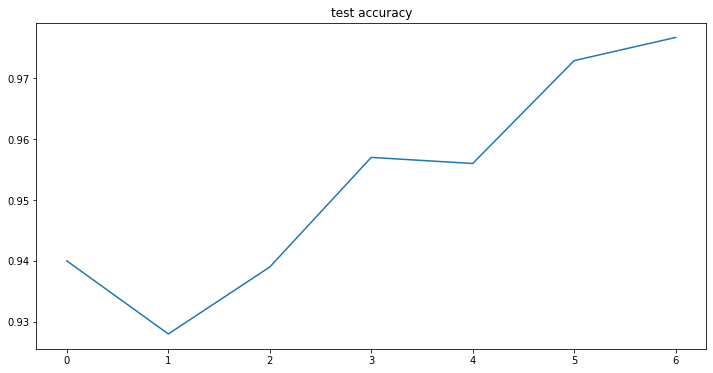

In [77]:
sns.lineplot(data=acc[1:]).set_title('test accuracy')
None

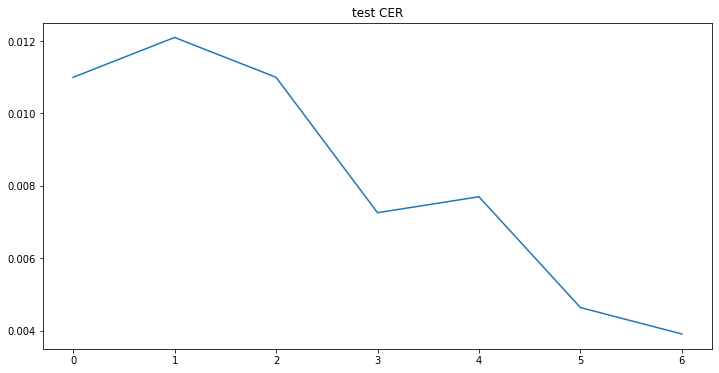

In [79]:
sns.lineplot(data=cer[1:]).set_title('test CER')
None

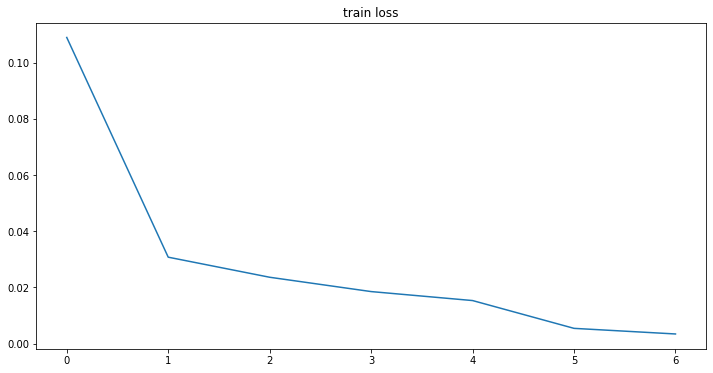

In [80]:
sns.lineplot(data=train_loss).set_title('train loss')
None

Как можно увидеть, модель хорошо обучилась и показывает хороший скор. Особенно CER, он очень маленький, поэтому можно сделать вывод, что модель изредка ошибается в некоторых символах (скорее всего иероглифах). Сейчас проверим мою гипотезу, проанализируя неправильные предикты модели. Также видно, что точность постепенно растёт на тестовой выборке - значит модель не переобучается. Хотя с этим можно поспорить, так как у нас всё ещё достаточно мало представителей классов различных провинций(разные иероглифы). И вероятно моя балансировка классов была слишком маленькой и надо было добавлять больше файлов (больше чем 200) для каждого малочисленного класса. Сейчас давайте проверим это

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


real: 皖AS850U, pred: 皖AS8501


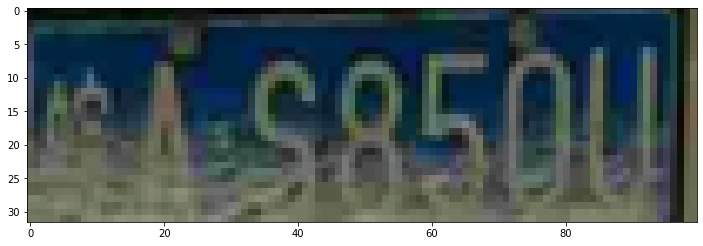

In [96]:
l = 0
for images, labels in val_loader:
    predicts = predict(images, model, tokenizer, DEVICE)
    for i in range(batch_size):
        if labels[i] != predicts[i]:
            print(f'real: {labels[i]}, pred: {predicts[i]}')
            imshow(images[i])
            l = 1
            break
    if l == 1:
        break

Как можно заметить на этом примере, иероглиф предсказан правильно, но качество фотографии очень плохое. Последний символ видимо был распознан CTC лосом как 2 единицы и схлопнут в итоге в одну, если я правильно понимаю работу СТС лоса

real: 粤DHZ909, pred: 闽DHZ909


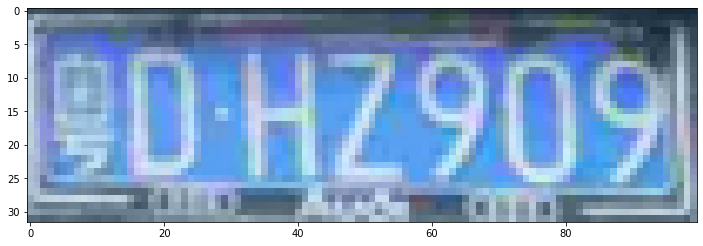

In [97]:
l = 0
for images, labels in val_loader:
    predicts = predict(images, model, tokenizer, DEVICE)
    for i in range(batch_size):
        if labels[i] != predicts[i]:
            print(f'real: {labels[i]}, pred: {predicts[i]}')
            imshow(images[i])
            l = 1
            break
    if l == 1:
        break

На этой ошибке видна проблема балансировки классов, предсказан неправильный иероглиф. Но что тут можно выделить положительного - так это то, что модель не предсказала самый популярный иероглиф, значит наша балансировка классов всё таки даёт свои плоды и модель лучше взаимодействует с малочисленными иероглифами

real: 皖AHFQ24, pred: 皖AMFQ24


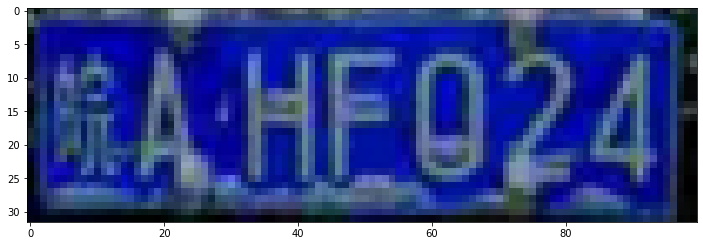

In [100]:
l = 0
for images, labels in val_loader:
    predicts = predict(images, model, tokenizer, DEVICE)
    for i in range(batch_size):
        if labels[i] != predicts[i]:
            print(f'real: {labels[i]}, pred: {predicts[i]}')
            imshow(images[i])
            l = 1
            break
    if l == 1:
        break

На этой картинке неправильно предсказана буква H, которая из за каких то видимо внешних помех стала похожа на букву М

real: 皖AD0T89, pred: 皖AD0TQ9


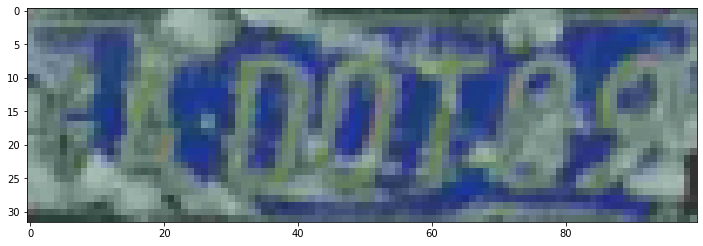

In [101]:
l = 0
for images, labels in val_loader:
    predicts = predict(images, model, tokenizer, DEVICE)
    for i in range(batch_size):
        if labels[i] != predicts[i]:
            print(f'real: {labels[i]}, pred: {predicts[i]}')
            imshow(images[i])
            l = 1
            break
    if l == 1:
        break

Здесь же мы можем увидеть очень плохое качество автомобильного номера, он весь в грязи, но при этом разница между оригиналом и предсказанием - всего лишь ошибка в выборе между Q и 0, которую модель совершила из за того, по моему предположению, что внутри 0 много белого цвета, и на фичер мапе вероятно он ближе к Q, чем к 0

Подводя итог предсказаниям и в целом тому как обучилась модель, хочу отметить, что по-хорошему надо обучать на большее колличество эпох и с нормально настроенным шедуляром. Но к сожалению колаб не даст обучить модель на много эпох в одном блокноте. Что касается моих ошибок, которые я сразу бы исправил, будь у меня время и вычислительные мощности - сделал нормальный шедулер, сделал балансировку классов ещё более обширной, поставил бы обучение минимум на 30 эпох, последил бы за лосами в различных комбинациях гиперпараметров. Сделал бы аугментацию. Её я не стал делать, потому что модель и так очень долго обучается, а своих вычислительных мощностей у меня нет.

# Отчёт

В отчёте я наверное хотел бы подытожить то, чему я научился за время выполнения данного задания. Ведь всё таки это будут читать люди и хочется поделиться своими мыслями по поводу проделанной работы. У меня уже давно в голове крутилась мысль, как реализовать сетку, которая с картинки будет считывать текст. Но ни на хакатонах, ни на курсах подобные задания не попадались. И вот наконец мне выпала возможность разобраться в теме и реализовать подобную сетку. Спасибо за такой подарок на новый год) Я прочитал кучу информации по распознаванию и детекции текста, понял как реализуется LSTM и CTC лосс. CTC лосс поистине невероятная вещь. Также узнал новую для себя метрику RES. Кстати ещё хочу добавить про исправление ошибок, наверное стоит попробовать другие фьючер-экстракторы и опять же поиграться с гиперпараметрами. Уверен я подобрал не самые оптимальные. Всегда очень интересно разбираться в относительно новой теме и я рад, что мне в очередной раз довелось узнать что-то новое. Отчёт плучился не очень обширным и предполагаю, что стоит было собрать больше данных по ходу обучения, например валидационный лосс остался за кадром, а это печально, ведь по нему можно понять, переобучается модель, или нет. Но как бы то ни было, метрики получились достаточно неплохими. В этой задаче конечно можно 0.99+ скор выбить, ведь из проблем датасета присутствует разве что плохое качество некоторых фотографий и плохая балансировка классов. 

Не знаю чем можно закончить этот отчёт и что ещё сюда добавить, оставлю концовку этого ноутбука открытой